# on combined_dataset

## Import Necessary Libraries



Explanation: We import essential libraries for file handling, dataset splitting, model training, and visualization. Logging is configured to track progress and debug issues effectively.



In [5]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from ultralytics import YOLO
import logging
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

logger.info("Libraries imported and random seeds set for reproducibility.")


2025-03-28 09:54:54,363 - INFO - Libraries imported and random seeds set for reproducibility.


## Define Paths and Split Dataset



Explanation: This cell sets up the directory structure and splits the augmented dataset into training, validation, and test sets. It ensures all images have corresponding labels and logs the process for transparency.



In [2]:
# Define paths using absolute paths
dataset_dir = Path('../yolo_dataset').resolve()  # Resolve to absolute path
augmented_images_dir = Path('../datasets/combined_dataset/images').resolve()
augmented_labels_dir = Path('../datasets/combined_dataset/labels').resolve()

train_images_dir = dataset_dir / 'images' / 'train'
val_images_dir = dataset_dir / 'images' / 'val'
test_images_dir = dataset_dir / 'images' / 'test'
train_labels_dir = dataset_dir / 'labels' / 'train'
val_labels_dir = dataset_dir / 'labels' / 'val'
test_labels_dir = dataset_dir / 'labels' / 'test'

# Create directories if they don’t exist
for dir_path in [train_images_dir, val_images_dir, test_images_dir, 
                 train_labels_dir, val_labels_dir, test_labels_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)
    logger.info(f"Created directory: {dir_path}")

# Get list of all images
image_files = list(augmented_images_dir.glob('*.jpg'))
label_files = [augmented_labels_dir / (img.stem + '.txt') for img in image_files]

# Verify dataset integrity
missing_labels = [img for img, lbl in zip(image_files, label_files) if not lbl.exists()]
if missing_labels:
    logger.warning(f"Found {len(missing_labels)} images without labels: {missing_labels[:5]}")
else:
    logger.info("Dataset integrity verified: All images have corresponding labels.")

# Split dataset: 70% train, 15% val, 15% test
train_images, temp_images = train_test_split(image_files, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

# Function to copy files
def copy_files(image_list, target_image_dir, target_label_dir):
    for img in image_list:
        label = augmented_labels_dir / (img.stem + '.txt')
        shutil.copy(img, target_image_dir / img.name)
        shutil.copy(label, target_label_dir / label.name)
        logger.debug(f"Copied {img.name} and its label to {target_image_dir} and {target_label_dir}")

# Copy files to respective directories
copy_files(train_images, train_images_dir, train_labels_dir)
copy_files(val_images, val_images_dir, val_labels_dir)
copy_files(test_images, test_images_dir, test_labels_dir)

logger.info(f"Dataset split completed: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test images.")


2025-03-28 09:49:38,710 - INFO - Created directory: /home/r0jin/projects/EnigmaAI/yolo_dataset/images/train
2025-03-28 09:49:38,711 - INFO - Created directory: /home/r0jin/projects/EnigmaAI/yolo_dataset/images/val
2025-03-28 09:49:38,712 - INFO - Created directory: /home/r0jin/projects/EnigmaAI/yolo_dataset/images/test
2025-03-28 09:49:38,713 - INFO - Created directory: /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/train
2025-03-28 09:49:38,714 - INFO - Created directory: /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/val
2025-03-28 09:49:38,715 - INFO - Created directory: /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/test
2025-03-28 09:49:40,921 - INFO - Dataset integrity verified: All images have corresponding labels.
2025-03-28 09:53:58,475 - INFO - Dataset split completed: 49630 train, 10635 val, 10636 test images.


## Create Dataset Configuration File (data.yaml)



Explanation: The data.yaml file is essential for YOLO training, specifying dataset paths and class names. This matches the classes from the augmentation task.



In [ ]:
# Define class names from the preprocessing task
class_names = [     
    'door',        # 0
    'table',       # 1
    'openedDoor',  # 2
    'chair',       # 3
    'pole',        # 4
    'bike',        # 5
    'truck',       # 6
    'car',         # 7
    'dog',         # 8
    'bus'          # 9
]

# Create data.yaml content with absolute paths
data_yaml_content = f"""
train: {train_images_dir}
val: {val_images_dir}
test: {test_images_dir}

nc: {len(class_names)}
names: {class_names}
"""

# Save data.yaml
data_yaml_path = dataset_dir / 'data.yaml'
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content.strip())
logger.info(f"Created dataset configuration file at {data_yaml_path}")


2025-03-26 11:57:32,010 - INFO - Created dataset configuration file at /home/r0jin/projects/EnigmaAI/yolo_dataset/data.yaml


## Set Up YOLO Model and GPU



Explanation: We leverage the RTX 2070 GPU by checking CUDA availability and load the lightweight YOLOv8 nano model as a baseline, ensuring fast training without optimizations.



In [ ]:
# Check GPU availability (RTX 2070)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f"Using device: {device}")
if device == 'cuda':
    logger.info(f"GPU detected: {torch.cuda.get_device_name(0)}")

# Load YOLOv8s model as baseline
model = YOLO('yolov8s.pt')  
model.to(device)
logger.info("Loaded YOLOv8s model and moved to GPU.")

2025-03-26 11:57:32,090 - INFO - Using device: cuda
2025-03-26 11:57:32,091 - INFO - GPU detected: NVIDIA GeForce RTX 2070 with Max-Q Design


100%|██████████| 21.5M/21.5M [00:03<00:00, 6.00MB/s]
2025-03-26 11:57:38,934 - INFO - Loaded YOLOv8s model and moved to GPU.


## Train the Baseline Model



Explanation: The model is trained on the augmented dataset using the GPU. Training logs are saved in runs/train/baseline_yolo, and the model weights are explicitly saved for evaluation.



In [ ]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load model
model = YOLO('yolov8s.pt')  
device = 'cuda'  # Or 0 if multiple GPUs

# Training parameters
epochs = 100  # Increased for more training time
batch_size = 8 
accumulate = 4  # Gradient accumulation to simulate batch size of 16

# Train with adjusted parameters
logger.info("Starting training with improved settings...")
results = model.train(
    data=str(data_yaml_path), 
    epochs=epochs,
    batch=batch_size,
    imgsz=640, 
    patience=10,  # Early stopping if no improvement
    device=device,
    project='runs/train',
    name='baseline_yolo',
    save=True,
    verbose=True,
    # Adjusted augmentation settings
    degrees=10.0,  # Reduced rotation
    translate=0.1,  # Reduced translation
    scale=0.5,    # Reduced scaling
    shear=2.0,    # Reduced shearing
    mosaic=0.5,   # Lowered mosaic probability
    mixup=0.0,    # Disabled mixup
    copy_paste=0.0,  # Disabled copy-paste
    fliplr=0.5,   # Kept horizontal flip
    # Hyperparameters
    lr0=0.002,    # Slightly higher learning rate
    lrf=0.01,     # Final learning rate factor
    momentum=0.937,  
    weight_decay=0.0005,  
    warmup_epochs=3,  
    cos_lr=True,  # Cosine scheduler

)

# Save model
model_path = 'baseline_yolo.pt'
model.save(model_path)
logger.info(f"Model saved to {model_path}")

2025-03-26 11:57:38,983 - INFO - Starting training with improved settings...


Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7959MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/r0jin/projects/EnigmaAI/yolo_dataset/data.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=runs/train, name=baseline_yolo, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

100%|██████████| 5.35M/5.35M [00:01<00:00, 4.62MB/s]


AMP: checks passed ✅


train: Scanning /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/train... 49630 images, 41068 backgrounds, 0 corrupt: 100%|██████████| 49630/49630 [00:28<00:00, 1743.69it/s]

train: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/train/w_10004937.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/train/w_10005130.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/train/w_10006682.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/train/w_10008077.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/train/w_20005056.jpg: corrupt JPEG restored and saved


train: New cache created: /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/val... 10635 images, 8829 backgrounds, 0 corrupt: 100%|██████████| 10635/10635 [00:03<00:00, 2766.99it/s]

val: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/val/w_30008475.jpg: 1 duplicate labels removed


val: New cache created: /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/val.cache
Plotting labels to runs/train/baseline_yolo/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/baseline_yolo
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.39G      1.522      4.834      1.227          9        640: 100%|██████████| 6204/6204 [15:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:10<00:00,  9.41it/s]


                   all      10635      12538      0.595       0.28      0.286      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.39G      1.677      2.457      1.353          8        640: 100%|██████████| 6204/6204 [15:10<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:07<00:00,  9.81it/s]


                   all      10635      12538      0.608      0.154      0.167     0.0729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.39G      1.967      3.006      1.632          0        640: 100%|██████████| 6204/6204 [16:04<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:15<00:00,  8.86it/s]


                   all      10635      12538      0.335      0.112     0.0929     0.0362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.39G       1.99      3.036      1.721         13        640: 100%|██████████| 6204/6204 [15:07<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:09<00:00,  9.62it/s]


                   all      10635      12538      0.398      0.113      0.121     0.0505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.39G      1.895       2.79      1.666          9        640: 100%|██████████| 6204/6204 [15:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:18<00:00,  8.47it/s]


                   all      10635      12538      0.431      0.153      0.161       0.07

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.39G      1.793      2.576      1.589          2        640: 100%|██████████| 6204/6204 [14:47<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:08<00:00,  9.72it/s]


                   all      10635      12538      0.723      0.175       0.18     0.0805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.39G      1.759      2.441      1.557          0        640: 100%|██████████| 6204/6204 [15:02<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:07<00:00,  9.84it/s]


                   all      10635      12538      0.742      0.184      0.191     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.39G      1.703      2.345      1.521          1        640: 100%|██████████| 6204/6204 [15:02<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:07<00:00,  9.80it/s]


                   all      10635      12538      0.545      0.192      0.211      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.39G      1.675      2.248      1.493         21        640: 100%|██████████| 6204/6204 [15:14<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:10<00:00,  9.48it/s]


                   all      10635      12538      0.648      0.192      0.205     0.0984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.39G      1.641      2.226      1.473          0        640: 100%|██████████| 6204/6204 [15:13<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:09<00:00,  9.59it/s]


                   all      10635      12538      0.743       0.22      0.245      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.39G      1.644      2.217      1.481         13        640: 100%|██████████| 6204/6204 [15:13<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:08<00:00,  9.72it/s]


                   all      10635      12538      0.745      0.218      0.266      0.118
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

11 epochs completed in 3.013 hours.
Optimizer stripped from runs/train/baseline_yolo/weights/last.pt, 22.5MB
Optimizer stripped from runs/train/baseline_yolo/weights/best.pt, 22.5MB

Validating runs/train/baseline_yolo/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7959MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:07<00:00,  9.85it/s]


                   all      10635      12538      0.595       0.28      0.286      0.146
                  door         49         80          1          0     0.0241     0.0145
                 table         24         30          1          0      0.058     0.0176
            openedDoor         11         12          0          0          0          0
                 chair         17         33       0.81     0.0909      0.204      0.121
                  pole       1269       4626      0.326      0.536      0.319     0.0989
                  bike        847       2724      0.524      0.531      0.528       0.25
                 truck        377        511      0.583      0.131      0.233      0.132
                   car       1114       4103      0.648      0.596      0.632      0.324
                   dog        117        144      0.426      0.562       0.47       0.28
                   bus        217        275      0.636      0.353      0.392      0.225
Speed: 0.3ms preproce

2025-03-26 15:01:07,707 - INFO - Model saved to baseline_yolo.pt


## Evaluate the Model



Explanation: The trained model is evaluated on the validation set, with key metrics (mAP and loss) logged for documentation, satisfying the deliverable of initial training metrics.



In [ ]:
# Load trained model
model = YOLO(model_path)
logger.info(f"Loaded model from {model_path}")

# Perform validation
val_results = model.val(data=str(data_yaml_path), split='val')

# Extract and log key metrics
map50 = val_results.box.map50  # mAP at IoU=0.5
map50_95 = val_results.box.map  # mAP at IoU=0.5:0.95

logger.info(f"Validation mAP50: {map50:.4f}")
logger.info(f"Validation mAP50-95: {map50_95:.4f}")

2025-03-26 15:01:08,322 - INFO - Loaded model from baseline_yolo.pt


Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7959MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /home/r0jin/projects/EnigmaAI/yolo_dataset/labels/val.cache... 10635 images, 8829 backgrounds, 0 corrupt: 100%|██████████| 10635/10635 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/r0jin/projects/EnigmaAI/yolo_dataset/images/val/w_30008475.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 665/665 [01:45<00:00,  6.29it/s]


                   all      10635      12538      0.595       0.28      0.286      0.146
                  door         49         80          1          0      0.024     0.0144
                 table         24         30          1          0     0.0561     0.0173
            openedDoor         11         12          0          0          0          0
                 chair         17         33      0.811     0.0909      0.204      0.121
                  pole       1269       4626      0.326      0.536       0.32      0.099
                  bike        847       2724      0.521       0.53      0.527       0.25
                 truck        377        511      0.581      0.131      0.233      0.132
                   car       1114       4103      0.649      0.597      0.632      0.325
                   dog        117        144      0.424      0.563      0.468       0.28
                   bus        217        275      0.636      0.353      0.392      0.224
Speed: 0.3ms preproce

2025-03-26 15:02:58,621 - INFO - Validation mAP50: 0.2857
2025-03-26 15:02:58,622 - INFO - Validation mAP50-95: 0.1464


## Visualize Training Metrics



Explanation: Training and validation loss, along with mAP, are plotted to visualize model performance. This assumes YOLOv8 saves a results.csv file.



In [9]:
csv_path = Path('/home/r0jin/projects/EnigmaAI/code/runs/train/baseline_yolo/results.csv')

# Read CSV
df = pd.read_csv(csv_path)

print(df.columns)


Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


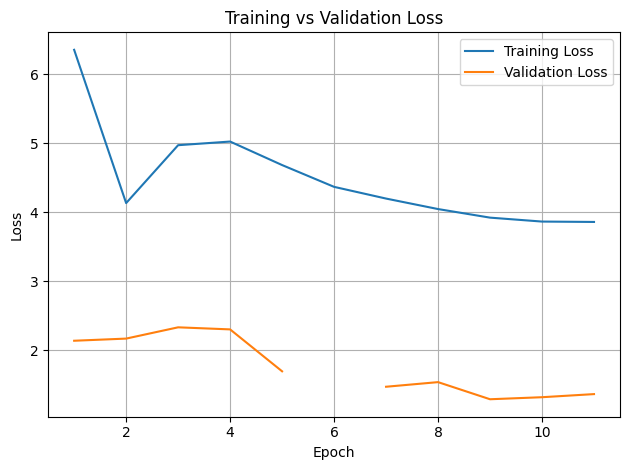

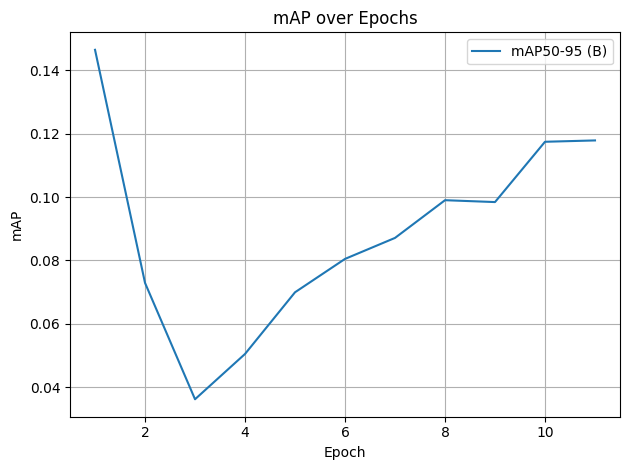

In [10]:
# 1) Plot Training vs. Validation Loss (box + cls losses)
plt.figure()
train_loss = df['train/box_loss'] + df['train/cls_loss']
val_loss = df['val/box_loss'] + df['val/cls_loss']
plt.plot(df['epoch'], train_loss, label='Training Loss')
plt.plot(df['epoch'], val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Plot mAP over Epochs (mAP50-95)
plt.figure()
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95 (B)')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualize Sample Predictions



Explanation: We run inference on three random validation images and display the predictions, providing a visual check of the model’s performance.



In [ ]:
# Select random validation images
sample_images = random.sample(list(val_images_dir.glob('*.jpg')), 3)
logger.info(f"Visualizing predictions for {len(sample_images)} sample validation images.")

for img_path in sample_images:
    # Run inference
    results = model.predict(img_path, device=device)
    
    # Show predictions
    results[0].save(f"prediction_{img_path.name}")
    logger.info(f"Saved prediction for {img_path.name}")

2025-03-26 11:17:19,789 - INFO - Visualizing predictions for 3 sample validation images.



image 1/1 /home/r0jin/projects/EnigmaAI/yolo_dataset/images/val/r_data85_jpg.rf.522e93df2703c9e782c9effabc83fbe6.jpg: 640x640 (no detections), 17.8ms
Speed: 1.4ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-03-26 11:17:19,855 - INFO - Saved prediction for r_data85_jpg.rf.522e93df2703c9e782c9effabc83fbe6.jpg



image 1/1 /home/r0jin/projects/EnigmaAI/yolo_dataset/images/val/r_465_png_jpg.rf.f86909e909e63225a43f598fbc12aee9.jpg: 640x640 (no detections), 17.5ms
Speed: 1.3ms preprocess, 17.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-03-26 11:17:19,882 - INFO - Saved prediction for r_465_png_jpg.rf.f86909e909e63225a43f598fbc12aee9.jpg



image 1/1 /home/r0jin/projects/EnigmaAI/yolo_dataset/images/val/r_240522_elevator_1383_jpg.rf.06b3eb4f015aaed0464a748c1adb5f40.jpg: 640x640 (no detections), 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-03-26 11:17:19,909 - INFO - Saved prediction for r_240522_elevator_1383_jpg.rf.06b3eb4f015aaed0464a748c1adb5f40.jpg
